# Лабораторная работа 2: Использование численных методов в задачах оптимизации
_Команда 10_ <br>
_Сурнаков, Ковалев, Нетроголов, Тюрин_

## 1. Поиск минимума функции:

\begin{align}
f(x)= \frac {1}{2} [ (x_ {1})^ {2} + \sum _ {i=1}^ {2} (x_ {i}-x_ {i+1})^ {2} + (x_ {3})^ {2} ]- x_ {1}
\end{align}

### Представление применимости алгоритмов BFGS и L-BFGS к данной оптимизационной задаче

In [344]:
import numpy as np
import sympy as sp
import pandas as pd


def function(x, grad_calc=False):
    """
    Inputs:
      x: iterable - values of x;
      grad_calc: optional - convert the formula to sympy or not.
    Returns:
      value: the value corresponding to the function and the values of 'x'.
      If 'grad_calc' is 'True', then instead of 'value' returns (formula, vars):
      formula: the sympy formula of the function with sympy.symbols instead of
          variable values.;
      vars: list of variables of function as sympy.symbols.
    """
    if grad_calc:
        vars = sp.symbols(f'x_:{len(x)}')
        formula = 0.5 * (vars[0]**2 + (vars[0]-vars[1])**2 +\
                  (vars[1]-vars[2])**2 + vars[2]**2) - vars[0]
        return formula, vars
    else:
        vars = x.copy()
        value = 0.5 * (vars[0]**2 + (vars[0]-vars[1])**2 +\
                (vars[1]-vars[2])**2 + vars[2]**2) - vars[0]
        return value

def is_convex(function, x_num):
    """
    Checks the function for convexity.
    """
    # Создаем DataFrame с значениями функции
    x_list = [np.ones(x_num) * i for i in range(-10, 10)]
    df_f = pd.DataFrame({'x': x_list,
                     'f_x': [function(x) for x in x_list]})

    # Вычисляем разность между последовательными значениями f(x)
    df_f['diff'] = df_f['f_x'].diff()

    # Проверяем, является ли разность неотрицательной
    return df_f['diff'].dropna().is_monotonic_increasing

def is_twice_differentiable(function, x_num):
    """
    Checks whether the function is twice differentiable.
    """
    form, v = function(np.ones(x_num), grad_calc=True)
    diff_1 = []
    diff_2 = []
    # Вычисляем первые частные производные
    for var in v:
        diff_1.append(sp.diff(form, var))

    # Вычисляем вторые частные производные
    for i, d in enumerate(diff_1):
        diff_2.append(sp.diff(d, v[i]))

    # Проверяем, являются ли вторые производные непрырвными на всей числовой оси
    for i, di in enumerate(diff_2):
        interval = sp.calculus.util.continuous_domain(di, v[i], sp.S.Reals)
        if interval is not sp.S.Reals:
            return False
    return True

def bfgs_applicable(f, num_x):
    """
    Checks the applicability of the BFGS algorithm to the function.
    """
    is_conv = is_convex(f, num_x)
    if not is_conv:
        print("Функция должна быть выпуклой!")
    is_twice_differ = is_twice_differentiable(f, num_x)
    if not is_twice_differ:
        print("Функция должна быть дважды дифференцируема!")
    return is_conv and is_twice_differ

In [345]:
bfgs_applicable(function, 3)

True

### Реализация алгоритмов BFGS и L-BFGS

In [243]:
from time import time

def grad_analytical_auto(f, x):
    """
    Returns gradient, calculated analytically using partial derivatives.
    """
    grad = np.zeros_like(x, float)
    f, vars = f(x, grad_calc=True)
    for i in range(len(vars)):
        df_dx = sp.diff(f, vars[i])
        df_dx_value = df_dx.subs([(vars[j], x[j]) for j in range(len(vars))])
        grad[i] = df_dx_value
    return grad

def grad_analytical_man(f, x):
    """
    Returns gradient, calculated analytically using partial derivatives.
    """
    x_0, x_1, x_2 = x
    return np.array([2.0*x_0-x_1-1, -x_0+2.0*x_1-x_2, -x_1+2.0*x_2])

def grad_numerical(f, x, eps=1e-8):
    """
    Returns gradient, calculated numerically using the finite difference method.
    """
    grad = np.zeros_like(x, float)
    for i in range(len(x)):
        x_plus_eps = x.copy()
        x_plus_eps[i] += eps
        grad[i] = (f(x_plus_eps) - f(x)) / eps
    return grad

def zoom(f, gradient_function, grad, x, direction, alpha_low, alpha_high,\
         c_1=1e-4, c_2=0.9):
    """
    The function of the approximation algorithm for determining the values of α
    in the range from 'alpha_low' to 'alpha_high'.
    """
    while True:
        alpha = (alpha_low + alpha_high)/2
        x_new = x + alpha * direction
        f_x_new = f(x_new)

        if (f_x_new > f(x) + c_1 * alpha * np.dot(grad, direction)) or \
        (f_x_new >= f(x + alpha_low*direction)):
            alpha_high = alpha
        else:
            grad_new = gradient_function(f, x_new)
            if np.abs(np.dot(grad_new, direction)) <= \
            c_2 * np.abs(np.dot(grad, direction)):
                return alpha

            if np.dot(grad_new, direction) * (alpha_high-alpha_low) >= 0:
                alpha_high = alpha_low
            alpha_low = alpha

    return alpha

def find_alpha(f, gradient_function, x, direction, c_1=1e-4, c_2=0.9, \
               max_iters=1000, alpha_max=1e5):
    """
    A function for determining the magnitude of the step α along
    the search direction ('direction') under Wolfe conditions.
    """
    alpha = np.linspace(0.0, alpha_max, num=max_iters, endpoint=False)
    grad = gradient_function(f, x)
    i = 1
    while i < max_iters:
        x_new = x + alpha[i] * direction
        if (f(x_new) > f(x) + c_1 * alpha[i] * np.dot(grad, direction)) or \
        ((i>1) and (f(x_new) >= f(x+alpha[i-1]*direction))):
            return zoom(f, gradient_function, grad, x, direction, alpha[i-1], \
                        alpha[i], c_1, c_2)

        grad_new = gradient_function(f, x_new)
        if np.abs(np.dot(grad_new, direction)) <= \
        c_2 * np.abs(np.dot(grad, direction)):
            return alpha[i]

        if np.dot(grad, direction) >= 0:
            return zoom(f, gradient_function, grad, x, direction, alpha[i-1], \
                        alpha[i], c_1, c_2)
        i += 1

    return alpha_max


def bfgs(f, grad_type, H_type, x_init=np.asarray([1.0, 2.0, 3.0]),
         grad_func=None, tolerance=1e-6, max_iters=100, verbose=0):
    """
    A function implementing the BFGS algorithm.
    Inputs:
      f: Function to optimization;
      grad_type: Type of gradient calculating: 'analytical' or 'numerical';
      H_type: Type of initial approximation of inverse Hessian matrix - \n
      Identity matrix ('identity') or partial derivatives matrix ('dxdt');
      x_init: Initial values of x;
      grad_func: Function for analytical calculation of the gradient;
      tolerance: Threshold value for np.linalg.norm(grad) during optimization;
      max_iters: Limit on the maximum number of iterations;
      verbose: Output optimization history or not and how detailed (0, 1 or 2).
    Returns:
      x: Vector of x values giving the minimum of the function.
    """
    since = time()

    # Начальное приближение x
    x = x_init.copy()

    # Инициализация приближения матрицы обратного Гессиана
    if H_type == 'dxdt':
        H = H_initial(f, x)
    elif H_type == 'identity':
        H = np.eye(len(x))
    else: raise Exception(f"Incorrect Hessian initialization type.\n\
    Expected: H_type in ['dxdt', 'identity']. Got: {H_type}")

    # Определение функции для расчета градиента
    if grad_type == 'analytical':
        if grad_func is None:
            raise Exception("It is necessary to pass the function of analytical\
             calculation of the gradient to the 'grad_func' parameter.")
        gradient_function = grad_func
    elif grad_type == 'numerical':
        gradient_function = grad_numerical
    else: raise Exception(f"Incorrect gradient type.\n\
    Expected: grad_type in ['analytical', 'numerical']. Got: {grad_type}")

    # Оптимизация функции
    for iteration in range(max_iters):
        was = time()
        grad = gradient_function(f, x)
        if np.linalg.norm(grad) < tolerance:
            print(f"{iteration} iters.", end=' ')
            if verbose >= 1:
                print(f"norm(grad) ({np.linalg.norm(grad)}) < tolerance ({tolerance}).")
            break

        # Вычисление шага, используя метод линейного поиска
        direction = -np.dot(H, grad)
        c_1 = 1e-4
        c_2 = 0.9
        alpha = find_alpha(f, gradient_function, x, direction, c_1, c_2)
        x_new = x + alpha * direction

        # Вычисление коррекции для обратного гессиана
        s = x_new - x
        y = gradient_function(f, x_new) - grad
        rho = 1.0 / np.dot(y, s)
        A1 = np.eye(len(x)) - rho * np.outer(s, y)
        A2 = np.eye(len(x)) - rho * np.outer(y, s)
        H = np.dot(np.dot(A1, H), A2) + rho * np.outer(s, s)

        x = x_new
        if verbose >= 1:
            print(f"[{iteration}/{max_iters}] ({round((time()-was)//60)} min {round((time()-was)%60, 5)} sec).")
        if verbose == 2:
            print(f"f = {f(x)}\nx = {x};\ngrad = {grad};\nH =\n{H}")

    final = [round((time()-since)//60), round((time()-since)%60, 5)]
    print(f"Optimization was done for {final[0]} min {final[1]} sec.")
    print(f"f = {f(x)}\nx = {x};\ngrad = {grad};\nH =\n{H}", end='\n\n')

    return x, final


def lbfgs(f, grad_type, H_type, x_init=np.asarray([1.0, 2.0, 3.0]), m=5,
          grad_func=None, tolerance=1e-6, max_iters=100, verbose=0):
    """
    A function implementing the L-BFGS algorithm.
    Inputs:
      f: Function to optimization;
      grad_type: Type of gradient calculating: 'analytical' or 'numerical';
      H_type: Type of initial approximation of inverse Hessian matrix - \n
      Identity matrix ('identity') or partial derivatives matrix ('dxdt');
      x_init: Initial values of x;
      m: Number of recent iterations, the values from which are stored in memory;
      grad_func: Function for analytical calculation of the gradient;
      tolerance: Threshold value for np.linalg.norm(grad) during optimization;
      max_iters: Limit on the maximum number of iterations;
      verbose: Output optimization history or not and how detailed (0, 1 or 2).
    Returns:
      x: Vector of x values giving the minimum of the function.
    """
    since = time()

    # Начальное приближение x
    x = x_init.copy()

    # Инициализация приближения матрицы обратного Гессиана
    if H_type == 'dxdt':
        H = H_initial(f, x)
    elif H_type == 'identity':
        H = np.eye(len(x))
    else: raise Exception(f"Incorrect Hessian initialization type.\n\
    Expected: H_type in ['dxdt', 'identity']. Got: {H_type}")

    s_list = []
    y_list = []
    rho_list = []

    # Определение функции для расчета градиента
    if grad_type == 'analytical':
        if grad_func is None:
            raise Exception("It is necessary to pass the function of analytical\
             calculation of the gradient to the 'grad_func' parameter.")
        gradient_function = grad_func
    elif grad_type == 'numerical':
        gradient_function = grad_numerical
    else: raise Exception(f"Incorrect gradient type.\n\
    Expected: grad_type in ['analytical', 'numerical']. Got: {grad_type}")

    # Оптимизация функции
    for iteration in range(max_iters):
        was = time()
        grad = gradient_function(f, x)
        if np.linalg.norm(grad) < tolerance:
            print(f"{iteration} iters.", end =' ')
            if verbose >= 1:
                print(f"norm(grad) ({np.linalg.norm(grad)}) < tolerance ({tolerance}).")
            break

        # Определение направления шага
        # Two-loop recursion алгоритм для нахождения H*grad
        q = grad.copy()
        alphas = []
        for s, y, rho in zip(reversed(s_list), reversed(y_list),
                             reversed(rho_list)):
            alpha = rho * np.dot(s, q)
            q -= alpha * y
            alphas.append(alpha)
        r = np.dot(H, q)
        for s, y, rho, alpha in zip(s_list, y_list, rho_list, reversed(alphas)):
            beta = rho * np.dot(y, r)
            r += s * (alpha - beta)

        direction = -r

        # Вычисление шага, используя метод линейного поиска
        c_1 = 1e-4
        c_2 = 0.9
        alpha = find_alpha(f, gradient_function, x, direction, c_1, c_2)
        x_new = x + alpha * direction

        # Вычисление коррекции для обратного гессиана
        s = x_new - x
        y = gradient_function(f, x_new) - grad
        rho = 1.0 / np.dot(y, s)
        V = np.eye(len(x)) - rho * np.outer(y, s)
        H = np.dot(V.T, np.dot(H, V)) + rho * np.outer(s, s)

        # Очистка из памяти лишних векторов s, k и rho
        if len(s_list) == m:
            s_list.pop(0)
            y_list.pop(0)
            rho_list.pop(0)

        # Вычисление и сохранение s, y и rho
        s_list.append(s)
        y_list.append(y)
        rho_list.append(rho)

        x = x_new

        if verbose >= 1:
            print(f"[{iteration}/{max_iters}] ({round((time()-was)//60)} min {round((time()-was)%60, 5)} sec).")
        if verbose == 2:
            print(f"f = {f(x)}\nx = {x};\ngrad = {grad};\nH =\n{H}")

    final = [round((time()-since)//60), round((time()-since)%60, 5)]
    print(f"Optimization was done for {final[0]} min {final[1]} sec.")
    print(f"f = {f(x)}\nx = {x};\ngrad = {grad};\nH =\n{H}", end='\n\n')

    return x, final



### Приближение матрицы Гессе

In [183]:
def H_initial(f, x, h=1e-6):
    """
    A function for the initial approximation of the inverse Hesse matrix
    by partial derivatives which calculates using the finite difference method.
    Inputs:
      f: Function to optimization;
      x: Initial values of x;
      h: The value of a small step for calculating finite differences.
    Returns:
      H: The inverse Hesse matrix.
    """
    H = np.zeros((len(x), len(x)))
    for i in range(len(x)):
        e_i = np.eye(len(x))[i]
        for j in range(len(x)):
            e_j = np.eye(len(x))[j]
            H[i,j] = (f(x + h*e_i + h*e_j) - f(x + h*e_i) - \
                      f(x + h*e_j) + f(x)) / h**2
    return H

### Сравнение алгоритмов BFGS и L-BFGS

#### Аналитическое вычисление градиента

In [21]:
##### Инициализация Гессе через единичную матрицу

x1_1, _ = bfgs(f=function, grad_type='analytical', H_type='identity', grad_func=grad_analytical_man, tolerance=1e-6, max_iters=100, verbose=0)
x2_1, _ = lbfgs(f=function, grad_type='analytical', H_type='identity', m=5, grad_func=grad_analytical_man, tolerance=1e-6, max_iters=100, verbose=0)

27 iters. Optimization was done for 0 min 0.01505 sec.
f = -0.37499999999983585
x = [0.74999968 0.50000005 0.25000023];
grad = [-6.91655753e-07  1.92998179e-07  4.14886981e-07];
H =
[[0.66456267 0.39297762 0.15735285]
 [0.39297762 0.86651697 0.38367757]
 [0.15735285 0.38367757 0.64965963]]

24 iters. Optimization was done for 0 min 0.00668 sec.
f = -0.37499999999978034
x = [0.7500002  0.49999981 0.24999957];
grad = [ 5.90683172e-07 -1.50131565e-07 -6.75132803e-07];
H =
[[0.72443742 0.46614679 0.235163  ]
 [0.46614679 0.9586426  0.47957813]
 [0.235163   0.47957813 0.74156018]]



In [31]:
##### Инициализация Гессе через матрицу частных производных

x1_2, _ = bfgs(f=function, grad_type='analytical', H_type='dxdt', grad_func=grad_analytical_man, tolerance=1e-6, max_iters=100, verbose=0)
x2_2, _ = lbfgs(f=function, grad_type='analytical', H_type='dxdt', m=5, grad_func=grad_analytical_man, tolerance=1e-6, max_iters=100, verbose=0)

28 iters. Optimization was done for 0 min 0.02015 sec.
f = -0.37499999999980543
x = [0.7500005  0.50000017 0.25      ];
grad = [ 8.29902596e-07 -1.55890726e-07 -1.71885425e-07];
H =
[[0.72847939 0.43982038 0.20067314]
 [0.43982038 0.83238291 0.36145846]
 [0.20067314 0.36145846 0.63748817]]

29 iters. Optimization was done for 0 min 0.01249 sec.
f = -0.3749999999999207
x = [0.74999971 0.49999998 0.25000005];
grad = [-5.46901712e-07  1.84265187e-07  1.31031926e-07];
H =
[[0.70399801 0.41162673 0.18227261]
 [0.41162673 0.83065201 0.36929481]
 [0.18227261 0.36929481 0.65112481]]



#### Численное вычисление градиента

In [32]:
##### Инициализация Гессе через единичную матрицу

x1_3, _ = bfgs(f=function, grad_type='numerical', H_type='identity', tolerance=1e-6, max_iters=100, verbose=0)
x2_3, _ = lbfgs(f=function, grad_type='numerical', H_type='identity', m=5, tolerance=1e-6, max_iters=100, verbose=0)

27 iters. Optimization was done for 0 min 0.02219 sec.
f = -0.37499999999983535
x = [0.74999966 0.50000003 0.25000022];
grad = [-6.99440506e-07  1.88737914e-07  4.16333634e-07];
H =
[[0.66083286 0.39107362 0.15774453]
 [0.39107362 0.86729889 0.38550553]
 [0.15774453 0.38550553 0.65113003]]

24 iters. Optimization was done for 0 min 0.01316 sec.
f = -0.3749999999997782
x = [0.75000018 0.49999979 0.24999956];
grad = [ 5.93969318e-07 -1.49880108e-07 -6.71684930e-07];
H =
[[0.72329042 0.46617166 0.23591947]
 [0.46617166 0.95966379 0.48120401]
 [0.23591947 0.48120401 0.74370505]]



In [43]:
##### Инициализация Гессе через матрицу частных производных

x1_4, _ = bfgs(f=function, grad_type='numerical', H_type='dxdt', tolerance=1e-6, max_iters=100, verbose=0)
x2_4, _ = lbfgs(f=function, grad_type='numerical', H_type='dxdt', tolerance=1e-6, max_iters=100, verbose=0)

28 iters. Optimization was done for 0 min 0.01718 sec.
f = -0.37499999999981315
x = [0.75000049 0.50000016 0.24999999];
grad = [ 8.27116153e-07 -1.55431223e-07 -1.66533454e-07];
H =
[[0.72839496 0.43916178 0.19926721]
 [0.43916178 0.8319397  0.36097229]
 [0.19926721 0.36097229 0.63748202]]

29 iters. Optimization was done for 0 min 0.01121 sec.
f = -0.374999999999918
x = [0.7499997  0.49999995 0.25000004];
grad = [-5.44009282e-07  1.83186799e-07  1.38777878e-07];
H =
[[0.70746813 0.41379562 0.18534032]
 [0.41379562 0.83098888 0.3691805 ]
 [0.18534032 0.3691805  0.64981451]]



#### Вывод

По результатам сравнения двух методов оптимизации (BFGS и L-BFGS) прослеживается значительная разница в скорости работы алгоритмов:

> L-BFGS в среднем по результатам всех экспериментов, ожидаемо, оказался быстрее, чем BFGS, причем почти в 2 раза (`BFGS` > `L-BFGS`):

*   для аналитического задания градиента:
  
  `27 iters` `≈0.0151c` > `24 iters` `≈0.0067c` *(Инициализация H единичной матрицей)*,
    
  `28 iters` `≈0.0202c` > `29 iters` `≈0.0125c` *(Инициализация H матрицей частных производных)*;
*   для численного задания градиента:

  `27 iters` `≈0.0222c` > `24 iters` `≈0.0132c` *(Инициализация H единичной матрицей)*,
  
  `28 iters` `≈0.0172c` > `29 iters` `≈0.0112c` *(Инициализация H матрицей частных производных)*.


---


Причем:

> Численное задание градиента на основе метода конечных разностей в среднем заняло больше времени, чем аналитическое задание градиента для обоих алгоритмов (`аналит.` < `числ.`):

*   для BFGS:
  
  `27 iters` `≈0.0151c` < `27 iters` `≈0.0222c` *(Инициализация H единичной матрицей)*,
    
  `28 iters` `≈0.0202c` > `28 iters` `≈0.0172c` *(Инициализация H матрицей частных производных)*;
*   для L-BFGS:

  `24 iters` `≈0.0067c` < `24 iters` `≈0.0132c` *(Инициализация H единичной матрицей)*,
  
  `29 iters` `≈0.0125c` > `29 iters` `≈0.0112c` *(Инициализация H матрицей частных производных)*.


---


Способ начального приближения матрицы Гессе также влияет на скорость:

> Использование единичной матрицы в качестве начальной апроксимации обратной матрицы Гессе дало лучшую скорость оптимизации функции, чем использование матрицы частных производных (`единичн.` < `частн. производн.`):

*   для BFGS:
  
  `27 iters` `≈0.0151c` < `28 iters` `≈0.0202c` *(аналитическое задание градиента)*,
    
  `27 iters` `≈0.0222c` > `28 iters` `≈0.0172c` *(численное задание градиента)*;
*   для L-BFGS:

  `24 iters` `≈0.0067c` < `29 iters` `≈0.0125c` *(аналитическое задание градиента)*,
  
  `24 iters` `≈0.0132c` > `29 iters` `≈0.0112c` *(численное задание градиента)*.


---


И, конечно, в контексте скорости работы алгоритмов оптимизации очень значимым оказывается первоначальное приближение значений `x` функции:

In [16]:
_, _ = lbfgs(f=function, grad_type='analytical', H_type='identity',
         x_init=np.asarray([1554.0, -1200.0, -533231.3234]),
          grad_func=grad_analytical_man)
_, _ = lbfgs(f=function, grad_type='analytical', H_type='identity',
          x_init=np.asarray([1.0, 1.0, 1.0]), grad_func=grad_analytical_man)

48 iters. Optimization was done for 0 min 0.02388 sec.
f = -0.3749999999999016
x = [0.74999975 0.50000009 0.25000015];
grad = [-5.80229759e-07  2.77542361e-07  2.03038296e-07];
H =
[[0.64462961 0.36058845 0.13944733]
 [0.36058845 0.81902326 0.34898405]
 [0.13944733 0.34898405 0.64050032]]

22 iters. Optimization was done for 0 min 0.00736 sec.
f = -0.3749999999998713
x = [0.75000039 0.50000019 0.24999994];
grad = [ 5.91786801e-07  4.64737148e-08 -3.02974883e-07];
H =
[[0.74959073 0.49630533 0.24863386]
 [0.49630533 0.98885894 0.49107443]
 [0.24863386 0.49107443 0.74596248]]



## 2. Практическое применение: использование метода оптимизации L-BFGS для решения задачи логистической регрессии

### Представление набора данных

In [159]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X, y = load_iris(return_X_y=True)
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
pd_data = pd.DataFrame(X, columns=['sepal_l','sepal_w','petal_l','petal_w'])
pd_data['y']=y
pd_data = pd_data.loc[pd_data['y'] != 2]
X, y = np.asarray(pd_data.drop('y', axis=1)), np.asarray(pd_data.y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                    random_state=42)
pd_data

,sepal_l,sepal_w,petal_l,petal_w,y
0,-0.900681,1.019004,-1.340227,-1.315444,0
1,-1.143017,-0.131979,-1.340227,-1.315444,0
2,-1.385353,0.328414,-1.397064,-1.315444,0
3,-1.506521,0.098217,-1.283389,-1.315444,0
4,-1.021849,1.249201,-1.340227,-1.315444,0
...,...,...,...,...,...
95,-0.173674,-0.131979,0.251221,0.000878,1
96,-0.173674,-0.362176,0.251221,0.132510,1
97,0.432165,-0.362176,0.308059,0.132510,1
98,-0.900681,-1.282963,-0.430828,-0.130755,1


<Axes: xlabel='sepal_w', ylabel='petal_w'>

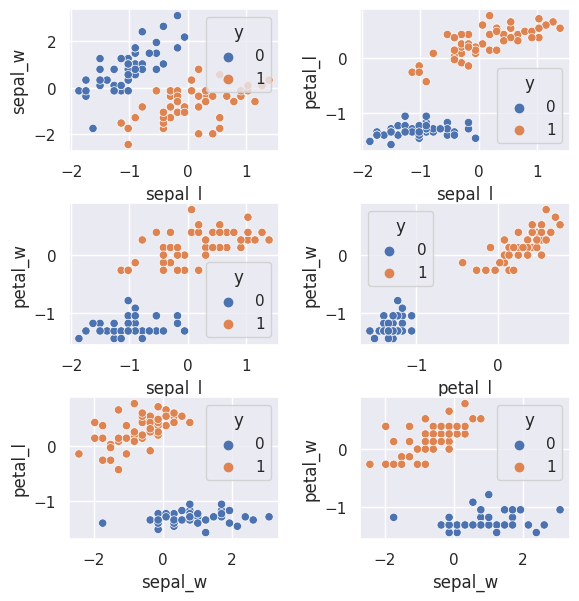

In [346]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
fig, axes = plt.subplots(3, 2, figsize=(6, 6))

fig.tight_layout()
sns.scatterplot(x=pd_data.sepal_l, y=pd_data.sepal_w, hue=pd_data.y, ax=axes[0,0])
sns.scatterplot(x=pd_data.sepal_l, y=pd_data.petal_l, hue=pd_data.y, ax=axes[0,1])
sns.scatterplot(x=pd_data.sepal_l, y=pd_data.petal_w, hue=pd_data.y, ax=axes[1,0])
sns.scatterplot(x=pd_data.petal_l, y=pd_data.petal_w, hue=pd_data.y, ax=axes[1,1])
sns.scatterplot(x=pd_data.sepal_w, y=pd_data.petal_l, hue=pd_data.y, ax=axes[2,0])
sns.scatterplot(x=pd_data.sepal_w, y=pd_data.petal_w, hue=pd_data.y, ax=axes[2,1])

### Реализация логистической регрессии

In [244]:
class LogRegLBFGS():
    def __init__(self, X, y):
        self.weights = None
        self.X = X
        self.y = y

    def sigmoid(self, x, weights):
        z = np.dot(x, weights)
        return 1.0 / (1.0 + np.exp(-z))

    def loss_function(self, weights):
        N = len(self.y)
        h = self.sigmoid(self.X, weights)
        # Рассчет функции потерь, добавив 1e-16, чтобы избежать ошибки при log(0)
        loss = -1/N * (np.dot(self.y.T, np.log(h+1e-16)) + \
                       np.dot((1-self.y).T, np.log(1-h+1e-16)))
        return loss

    def gradient_analytical(self, f, weights):
        N = len(self.y)
        h = self.sigmoid(self.X, weights)
        return 1/N * np.dot(self.X.T, (h - self.y))

    def fit(self, optimizator='lbfgs', grad_type='analytical',
            H_type='identity', m=5, tolerance=1e-6, max_iters=100, verbose=0):
        """
        A function implementing training process of the model.
        Inputs:
          optimizator: Optimization algorithm ('bfgs', 'lbfgs');
          grad_type: Type of gradient calculating: 'analytical' or 'numerical';
          H_type: Type of initial approximation of inverse Hessian matrix - \n
          Identity matrix ('identity') or partial derivatives matrix ('dxdt');
          m: Number of recent iterations, the values from which are stored in memory;
          tolerance: Threshold value for np.linalg.norm(grad) during optimization;
          max_iters: Limit on the maximum number of iterations;
          verbose: Output optimization history or not and how detailed (0, 1 or 2).
        Returns:
          t: Time of optimization process.
        """
        weights_init = np.zeros(self.X.shape[1])

        if grad_type == 'analytical':
            grad_func = self.gradient_analytical
        else: grad_func = None

        if optimizator == 'lbfgs':
            m = m
            self.weights, t = lbfgs(f=self.loss_function, grad_type=grad_type,
                                 H_type=H_type, x_init=weights_init,
                                 grad_func=grad_func, m=m, tolerance=tolerance,
                                 max_iters=max_iters, verbose=verbose)

        if optimizator == 'bfgs':
            self.weights, t = bfgs(f=self.loss_function, grad_type=grad_type,
                                H_type=H_type, x_init=weights_init,
                                grad_func=grad_func, tolerance=tolerance,
                                max_iters=max_iters, verbose=verbose)
        return t


    def predict(self, X_test):
        if self.weights is None:
            raise Exception("Model has not been trained yet.")
        y_prob = self.sigmoid(X_test, self.weights)
        return np.where(y_prob >= 0.5, 1, 0), y_prob

### Сравнение характеристики работы алгоритмов

#### Алгоритм оптимизации BFGS

##### Аналитический градиент

In [263]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Создание модели и ее обучение при помощи оптимизатора BFGS
model = LogRegLBFGS(X_train, y_train)
t1 = model.fit(optimizator='bfgs',
              grad_type='analytical',
              H_type='identity')

# Получаем предсказания и их вероятности
y_pred, probs = model.predict(X_test)

# Оценка точности предсказания
a1 = round(accuracy_score(y_test, y_pred), 2)
print("Accuracy: ", a1)
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                   columns=['Pred_0', 'Pred_1'],
                   index=['Actual_0', 'Actual_1']))

3 iters. Optimization was done for 0 min 0.00467 sec.
f = 1.888497290978145e-07
x = [  26.64763175 -105.71934302   58.62616273   59.38985127];
grad = [-3.07222050e-07 -3.29049019e-07 -2.63701685e-07 -2.23460624e-07];
H =
[[ 2.00779251e+01  2.97106199e+02 -7.79925974e+01 -1.01575440e+02]
 [ 2.97106199e+02  4.02610935e+04 -1.26813410e+04 -1.53550079e+04]
 [-7.79925974e+01 -1.26813410e+04  4.00983387e+03  4.84744295e+03]
 [-1.01575440e+02 -1.53550079e+04  4.84744295e+03  5.86548863e+03]]

Accuracy:  0.97
          Pred_0  Pred_1
Actual_0      19       0
Actual_1       1      13


In [264]:
# Обучение при помощи оптимизатора BFGS
model = LogRegLBFGS(X_train, y_train)
t2 = model.fit(optimizator='bfgs',
              grad_type='analytical',
              H_type='dxdt')

# Получаем предсказания и их вероятности
y_pred, probs = model.predict(X_test)

# Оценка точности предсказания
a2 = round(accuracy_score(y_test, y_pred), 2)
print("Accuracy: ", a2)
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                   columns=['Pred_0', 'Pred_1'],
                   index=['Actual_0', 'Actual_1']))

9 iters. Optimization was done for 0 min 0.0125 sec.
f = 7.604638810536637e-08
x = [ 54.44228948 -81.07055303  77.42340227  71.94215897];
grad = [6.73489650e-08 9.58234425e-08 3.21123909e-08 9.44894617e-09];
H =
[[  63284.68052012  -88254.3728621    87956.36907761   81801.3069581 ]
 [ -88254.3728621   123916.9019415  -122950.198347   -114336.61463623]
 [  87956.36907761 -122950.198347    122346.18828941  113781.23649041]
 [  81801.3069581  -114336.61463623  113781.23649041  105816.00046684]]

Accuracy:  1.0
          Pred_0  Pred_1
Actual_0      19       0
Actual_1       0      14


<ipython-input-244-ab77d08c79e3>:9: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


##### Численный градиент

In [265]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Создание модели и ее обучение при помощи оптимизатора BFGS
model = LogRegLBFGS(X_train, y_train)
t3 = model.fit(optimizator='bfgs',
              grad_type='numerical',
              H_type='identity')

# Получаем предсказания и их вероятности
y_pred, probs = model.predict(X_test)

# Оценка точности предсказания
a3 = round(accuracy_score(y_test, y_pred), 2)
print("Accuracy: ", a3)
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                   columns=['Pred_0', 'Pred_1'],
                   index=['Actual_0', 'Actual_1']))

3 iters. Optimization was done for 0 min 0.00787 sec.
f = 1.889627801050172e-07
x = [  26.64743595 -105.71918749   58.62593708   59.38965196];
grad = [-3.07386533e-07 -3.29259860e-07 -2.63805584e-07 -2.23538776e-07];
H =
[[ 2.00797011e+01  2.97217339e+02 -7.80267407e+01 -1.01617147e+02]
 [ 2.97217339e+02  4.02608526e+04 -1.26811633e+04 -1.53548354e+04]
 [-7.80267407e+01 -1.26811633e+04  4.00974589e+03  4.84734986e+03]
 [-1.01617147e+02 -1.53548354e+04  4.84734986e+03  5.86539219e+03]]

Accuracy:  0.97
          Pred_0  Pred_1
Actual_0      19       0
Actual_1       1      13


In [266]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Создание модели и ее обучение при помощи оптимизатора BFGS
model = LogRegLBFGS(X_train, y_train)
t4 = model.fit(optimizator='bfgs',
             grad_type='numerical',
              H_type='dxdt')

# Получаем предсказания и их вероятности
y_pred, probs = model.predict(X_test)

# Оценка точности предсказания
a4 = round(accuracy_score(y_test, y_pred), 2)
print("Accuracy: ", a4)
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                   columns=['Pred_0', 'Pred_1'],
                   index=['Actual_0', 'Actual_1']))

9 iters. Optimization was done for 0 min 0.01615 sec.
f = 2.8263211008132563e-08
x = [ 52.8189257  -79.93066287  75.55436142  70.19093575];
grad = [2.45243716e-08 3.44666848e-08 1.15993655e-08 3.31410475e-09];
H =
[[  61641.10023035  -87411.38559699   86171.22012406   80124.35210617]
 [ -87411.38559699  124824.64853478 -122496.24704366 -113890.3804449 ]
 [  86171.22012406 -122496.24704366  120566.30606401  112102.40980133]
 [  80124.35210617 -113890.3804449   112102.40980133  104232.81028081]]

Accuracy:  1.0
          Pred_0  Pred_1
Actual_0      19       0
Actual_1       0      14


<ipython-input-244-ab77d08c79e3>:9: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


#### Алгоритм оптимизации L-BFGS

##### Аналитический градиент

In [267]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Создание модели и ее обучение при помощи оптимизатора BFGS
model = LogRegLBFGS(X_train, y_train)
t5 = model.fit(optimizator='lbfgs',
             grad_type='analytical',
             H_type='identity')

# Получаем предсказания и их вероятности
y_pred, probs = model.predict(X_test)

# Оценка точности предсказания
a5 = round(accuracy_score(y_test, y_pred), 2)
print("Accuracy: ", a5)
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                   columns=['Pred_0', 'Pred_1'],
                   index=['Actual_0', 'Actual_1']))

3 iters. Optimization was done for 0 min 0.00342 sec.
f = 1.8643416085098326e-07
x = [  26.6524315  -105.72541237   58.63254787   59.39553419];
grad = [-3.03291235e-07 -3.24838898e-07 -2.60327768e-07 -2.20601648e-07];
H =
[[ 2.00338736e+01  2.94342480e+02 -7.71439106e+01 -1.00537818e+02]
 [ 2.94342480e+02  4.02682027e+04 -1.26861807e+04 -1.53596772e+04]
 [-7.71439106e+01 -1.26861807e+04  4.01217496e+03  4.84990367e+03]
 [-1.00537818e+02 -1.53596772e+04  4.84990367e+03  5.86801483e+03]]

Accuracy:  0.97
          Pred_0  Pred_1
Actual_0      19       0
Actual_1       1      13


In [268]:
# Обучение при помощи оптимизатора BFGS
model = LogRegLBFGS(X_train, y_train)
t6 = model.fit(optimizator='lbfgs',
              grad_type='analytical',
              H_type='dxdt')

# Получаем предсказания и их вероятности
y_pred, probs = model.predict(X_test)

# Оценка точности предсказания
a6 = round(accuracy_score(y_test, y_pred), 2)
print("Accuracy: ", a6)
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                   columns=['Pred_0', 'Pred_1'],
                   index=['Actual_0', 'Actual_1']))

6 iters. Optimization was done for 0 min 0.00838 sec.
f = 7.03660928862918e-11
x = [ 110.8508223  -159.70801694  155.50027431  144.48299752];
grad = [6.33768177e-11 9.02762069e-11 3.03153241e-11 9.20043221e-12];
H =
[[131118.80453063 -80627.51139307 147161.28421443 138075.85685431]
 [-80627.51139307  70560.67096932 -97617.50658586 -91266.09678772]
 [147161.28421443 -97617.50658586 167586.28568297 157129.59464825]
 [138075.85685431 -91266.09678772 157129.59464825 147330.31752653]]

Accuracy:  1.0
          Pred_0  Pred_1
Actual_0      19       0
Actual_1       0      14


<ipython-input-244-ab77d08c79e3>:9: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


##### Численный градиент

In [269]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Создание модели и ее обучение при помощи оптимизатора BFGS
model = LogRegLBFGS(X_train, y_train)
t7 = model.fit(optimizator='lbfgs',
             grad_type='numerical',
              H_type='identity')

# Получаем предсказания и их вероятности
y_pred, probs = model.predict(X_test)

# Оценка точности предсказания
a7 = round(accuracy_score(y_test, y_pred), 2)
print("Accuracy: ", a7)
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                   columns=['Pred_0', 'Pred_1'],
                   index=['Actual_0', 'Actual_1']))

3 iters. Optimization was done for 0 min 0.00601 sec.
f = 1.8654620808963673e-07
x = [  26.65222812 -105.72522548   58.63230496   59.39531748];
grad = [-3.03575216e-07 -3.25282833e-07 -2.60657105e-07 -2.20887426e-07];
H =
[[ 2.00357042e+01  2.94458030e+02 -7.71794212e+01 -1.00581191e+02]
 [ 2.94458030e+02  4.02679427e+04 -1.26859927e+04 -1.53594943e+04]
 [-7.71794212e+01 -1.26859927e+04  4.01208236e+03  4.84980563e+03]
 [-1.00581191e+02 -1.53594943e+04  4.84980563e+03  5.86791320e+03]]

Accuracy:  0.97
          Pred_0  Pred_1
Actual_0      19       0
Actual_1       1      13


In [270]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Создание модели и ее обучение при помощи оптимизатора BFGS
model = LogRegLBFGS(X_train, y_train)
t8 = model.fit(optimizator='lbfgs',
              grad_type='numerical',
             H_type='dxdt')

# Получаем предсказания и их вероятности
y_pred, probs = model.predict(X_test)

# Оценка точности предсказания
a8 = round(accuracy_score(y_test, y_pred), 2)
print("Accuracy: ", a8)
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                   columns=['Pred_0', 'Pred_1'],
                   index=['Actual_0', 'Actual_1']))

6 iters. Optimization was done for 0 min 0.01413 sec.
f = 6.003638560233719e-11
x = [ 110.60282536 -159.5345373   155.21480974  144.21548171];
grad = [0. 0. 0. 0.];
H =
[[131750.00203317 -81141.85198696 147912.57202331 138778.80947123]
 [-81141.85198696  70853.50743732 -98186.81805869 -91800.62332369]
 [147912.57202331 -98186.81805869 168465.94724952 157953.2876569 ]
 [138778.80947123 -91800.62332369 157953.2876569  148101.57565332]]

Accuracy:  1.0
          Pred_0  Pred_1
Actual_0      19       0
Actual_1       0      14


<ipython-input-244-ab77d08c79e3>:9: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


#### Вывод

In [276]:
columns = pd.MultiIndex.from_tuples([('Analit_grad', 'H_identity'),
                                     ('Analit_grad', 'H_dxdt'),
                                     ('Numeric_grad', 'H_identity'),
                                      ('Numeric_grad', 'H_dxdt')])
bfgs_time = [t1[1], t2[1], t3[1], t4[1]]
lbfgs_time = [t5[1], t6[1], t7[1], t8[1]]
df_time = pd.DataFrame([bfgs_time, lbfgs_time],
             columns=columns,
             index=['BFGS', 'L-BFGS'])
bfgs_acc = [a1, a2, a3, a4]
lbfgs_acc = [a5, a6, a7, a8]
df_acc = pd.DataFrame([bfgs_acc, lbfgs_acc],
             columns=columns,
             index=['BFGS', 'L-BFGS'])

Время работы алгоритмов сведено в таблицу:

In [277]:
df_time

Analit_grad          Numeric_grad         
        H_identity   H_dxdt   H_identity   H_dxdt
BFGS       0.00467  0.01250      0.00787  0.01615
L-BFGS     0.00342  0.00838      0.00601  0.01413

Точность предсказаний алгоритмов сведена в таблицу:

In [278]:
df_acc

Analit_grad        Numeric_grad       
        H_identity H_dxdt   H_identity H_dxdt
BFGS          0.97    1.0         0.97    1.0
L-BFGS        0.97    1.0         0.97    1.0

По результатам выполнения работы алгоритмов видно, что:

* Алгоритм оптимизации L-BFGS  действительно дает прирост в скорости работы в сравнении с BFGS;

* Численный метод задания градиента при помощи вычислений конечной разности хоть и дает меньшую скорость работы алгоритма оптимизации относительно аналитического способа задания градиента, но не уступает ему в точности;

* Использование матрицы частных производных в качестве начального приближения обратной матрицы Гессе дает лучшую точность предсказания в ущерб скорости работы алгоритма

